In [1]:
import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
import scipy
import networkx as nx
import copy
import time
import orqviz

In [2]:
qubit_number = 6
qubits = range(qubit_number)

In [3]:
G=nx.complete_graph(qubit_number)

In [4]:
for node in range(qubit_number):
    G.add_node(node)
    
G.nodes()

NodeView((0, 1, 2, 3, 4, 5))

In [5]:
for node in range(qubit_number):
    if node<qubit_number-1: 
        G.add_edge(node,node+1)
len(G.edges)

15

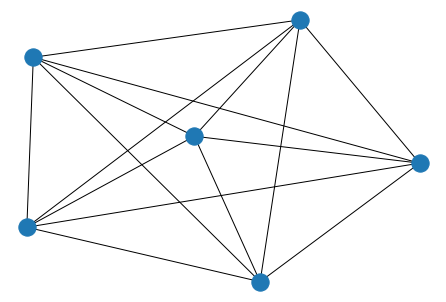

In [6]:
nx.draw(G)

In [7]:
def H_matrix(graph,edge_weights,no_of_qubits):
    # edge_weights= $\theta_1$ parameters for interaction terms
    # node_weights= $\theta_2$ parameters for single qubit terms
    
    full_matrix=np.zeros((2**no_of_qubits,2**no_of_qubits))
    
    # creating the two qubit interation terms:
    for i,edge in enumerate(graph.edges):
        
        zz_int=1
        
        for qubit in range(no_of_qubits):
            
            if qubit in edge:
                # for only ZZ interaction 
                zz_int=np.kron(zz_int,qml.PauliZ.matrix)
                
            else:
                zz_int=np.kron(zz_int,np.identity(2))
                
        full_matrix+=edge_weights[i]*zz_int*(-1)
        
        
    for i,edge in enumerate(graph.edges):
        
        xx_int=1
        
        for qubit in range(no_of_qubits):
            
            if qubit in edge:
                # for only XX interaction 
                xx_int=np.kron(xx_int,qml.PauliX.matrix)
                
            else:
                xx_int=np.kron(xx_int,np.identity(2))
                
        full_matrix+=edge_weights[i]*xx_int*(-1)
        
       
    for i,edge in enumerate(graph.edges):
        
        yy_int=1
        
        for qubit in range(no_of_qubits):
            
            if qubit in edge:
                # for only YY interaction 
                yy_int=np.kron(yy_int,qml.PauliY.matrix)
                
            else:
                yy_int=np.kron(yy_int,np.identity(2))
                
        full_matrix = full_matrix + edge_weights[i]*yy_int*(-1)
    
    return full_matrix

In [8]:
# generating gaussian numbers from box muller transformation

def generategaussian(n,var,mean):
    arr=[]
    
    u1=np.random.rand(n)
    u2=np.random.rand(n)
    arr.append(np.sqrt(var)*np.sqrt(-2*np.log(u1))*np.cos(2*np.pi*u2)+mean)
    arr.append(np.sqrt(var)*np.sqrt(-2*np.log(u1))*np.sin(2*np.pi*u2)+mean)
        
    return arr

In [9]:
Gaussians=generategaussian(10000,1,0)

In [10]:
from pylab import show,hist,subplot,figure

(array([[  10.,   89.,  507., 1559., 2783., 2678., 1708.,  563.,   94.,
            9.],
        [  13.,   77.,  530., 1542., 2719., 2809., 1640.,  547.,   98.,
           25.]]),
 array([-3.87004799, -3.10282342, -2.33559884, -1.56837427, -0.8011497 ,
        -0.03392513,  0.73329945,  1.50052402,  2.26774859,  3.03497316,
         3.80219774]),
 <a list of 2 BarContainer objects>)

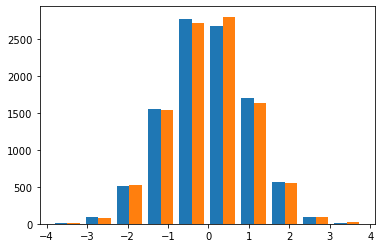

In [11]:
figure()
hist(Gaussians)

Defining the three variables except the interaction terms in the below cell

In [12]:
'''
Only the number of "runs" in the below cell should vary  
'''

'\nOnly the number of "runs" in the below cell should vary  \n'

In [13]:
run=1 # can be increased to have better results
# no transverse field in this model
mean=1  # mean value of the gaussian interactions Jij
var=np.linspace(0.8,1.8,7)  # variance of the gaussian interactions Jij
var=var[6:7]
var

array([1.8])

In [14]:
min_energy=[]
gaussian_arr=[]

start_time = time.time() 
for v in var:
    for i in range(run):
        edge_weights =generategaussian(len(G.edges),v,mean)[0]
        gaussian_arr.append(edge_weights)
        Ham=H_matrix(G,edge_weights,qubit_number)
        min_energy.append(np.real_if_close(min(np.linalg.eig(Ham)[0])))
print("Total elements",len(min_energy))
end_time = time.time()
print('Total time taken: ', (end_time-start_time)/60, ' mins.')

min_eng=[]
for j in range(len(var)):
    min_eng.append(np.sum(min_energy[run*j:run*(j+1)])/len(min_energy[run*j:run*(j+1)]))

print("The energy array->",(min_eng))


Total elements 1
Total time taken:  0.0012115637461344402  mins.
The energy array-> [-15.750023006247428]


In [26]:
#####################################################

Try couple of times to make the above plot as much as smooth, if that doesn't work try to increase the "run by 20" 

In [18]:
#####################################################

In [15]:
print(f"Minimum average eigen energies:{min_eng}")

Minimum average eigen energies:[-15.750023006247428]


In [16]:
dev = qml.device("lightning.qubit", wires= qubit_number) # 16 register qubits 

In [17]:
wires=list(range(qubit_number)) # will be used below
print("length of wires",len(wires))
for i in wires:
    print("wire->",i)
print("length of edges",len(G.edges))

length of wires 6
wire-> 0
wire-> 1
wire-> 2
wire-> 3
wire-> 4
wire-> 5
length of edges 15


In [18]:
[wires[0],wires[2]+1]

[0, 3]

In [19]:
'''
For a complete graph the below ansatz has to be defined separately
'''

'\nFor a complete graph the below ansatz has to be defined separately\n'

In [20]:
def SU4(l,wires=None):
    if len(l)!=15:
        raise ValueError('Incorrect parameters')
    
    
    else:
        qml.RZ(l[0],wires=wires[0])
        qml.RY(l[1],wires=wires[0])
        qml.RZ(l[2],wires=wires[0])
        qml.RZ(l[3],wires=wires[1])
        qml.RY(l[4],wires=wires[1])
        qml.RZ(l[5],wires=wires[1])
        qml.CNOT(wires=[wires[1],wires[0]])
        qml.RZ(l[6],wires=wires[0])
        qml.RY(l[7],wires=wires[1])
        qml.CNOT(wires=[wires[0],wires[1]])
        qml.RY(l[8],wires=wires[1])
        qml.CNOT(wires=[wires[1],wires[0]])
        qml.RZ(l[9],wires=wires[0])
        qml.RY(l[10],wires=wires[0])
        qml.RZ(l[11],wires=wires[0])
        qml.RZ(l[12],wires=wires[1])
        qml.RY(l[13],wires=wires[1])
        qml.RZ(l[14],wires=wires[1])

In [21]:
# Hardware efficient ansatz from paper "Certified variational quantum algorithms for eigenstate preparation"

def ansatz(l):
    
    if len(l)!=(qubit_number-1)*15:
        raise ValueError('Number of parameters are not correct!')
        
    else:
        
        for qubit in range(qubit_number-1):
            SU4(l[15*qubit:15*(1+qubit)],wires=[wires[qubit],wires[qubit+1]])
   # end...............................................


In [22]:
coeffs_toy = [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]
#qml.PauliZ(15)@qml.PauliZ(0),
obs_toy = [
    qml.PauliZ(0)@qml.PauliZ(1), qml.PauliZ(1)@qml.PauliZ(2), qml.PauliZ(2)@qml.PauliZ(3), qml.PauliZ(3)@qml.PauliZ(4),
     qml.PauliZ(4)@qml.PauliZ(5),qml.PauliZ(5)@qml.PauliZ(6),qml.PauliZ(6)@qml.PauliZ(7),qml.PauliZ(7)@qml.PauliZ(8),
    qml.PauliZ(8)@qml.PauliZ(9),qml.PauliZ(9)@qml.PauliZ(10),qml.PauliZ(10)@qml.PauliZ(11),qml.PauliZ(11)@qml.PauliZ(12),
    qml.PauliZ(12)@qml.PauliZ(13),qml.PauliZ(13)@qml.PauliZ(14),qml.PauliZ(14)@qml.PauliZ(15),
    qml.PauliX(0),qml.PauliX(1),qml.PauliX(2),qml.PauliX(3),qml.PauliX(4),qml.PauliX(5),qml.PauliX(6),qml.PauliX(7)
    ,qml.PauliX(8),qml.PauliX(9),qml.PauliX(10),qml.PauliX(11),qml.PauliX(12),qml.PauliX(13),qml.PauliX(14),qml.PauliX(15)

]
H_toy = qml.Hamiltonian(coeffs_toy, obs_toy)
print(H_toy)

  (-1) [X0]
+ (-1) [X1]
+ (-1) [X2]
+ (-1) [X3]
+ (-1) [X4]
+ (-1) [X5]
+ (-1) [X6]
+ (-1) [X7]
+ (-1) [X8]
+ (-1) [X9]
+ (-1) [X10]
+ (-1) [X11]
+ (-1) [X12]
+ (-1) [X13]
+ (-1) [X14]
+ (-1) [X15]
+ (-1) [Z0 Z1]
+ (-1) [Z1 Z2]
+ (-1) [Z2 Z3]
+ (-1) [Z3 Z4]
+ (-1) [Z4 Z5]
+ (-1) [Z5 Z6]
+ (-1) [Z6 Z7]
+ (-1) [Z7 Z8]
+ (-1) [Z8 Z9]
+ (-1) [Z9 Z10]
+ (-1) [Z10 Z11]
+ (-1) [Z11 Z12]
+ (-1) [Z12 Z13]
+ (-1) [Z13 Z14]
+ (-1) [Z14 Z15]


In [23]:
gaussian_arr[0]

array([ 3.16951564,  2.09715634,  0.11315357,  0.87442463,  1.75487098,
        1.13301797,  0.6491479 ,  0.91010959,  0.86541532,  1.64136908,
        0.04914871, -0.10989779,  0.64379321, -0.78674084, -2.09456542])

In [24]:
coeffs_arr=[]
for v1,v in enumerate(var):
    for i in range(run):
        coeffs =np.concatenate([-gaussian_arr[i+run*v1] for k in range(3)]) # [-1,-1,-1,-1,-1,-g,-g,-g,-g,-g,-g]
        coeffs_arr.append(coeffs)
(coeffs_arr)[0]

array([-3.16951564, -2.09715634, -0.11315357, -0.87442463, -1.75487098,
       -1.13301797, -0.6491479 , -0.91010959, -0.86541532, -1.64136908,
       -0.04914871,  0.10989779, -0.64379321,  0.78674084,  2.09456542,
       -3.16951564, -2.09715634, -0.11315357, -0.87442463, -1.75487098,
       -1.13301797, -0.6491479 , -0.91010959, -0.86541532, -1.64136908,
       -0.04914871,  0.10989779, -0.64379321,  0.78674084,  2.09456542,
       -3.16951564, -2.09715634, -0.11315357, -0.87442463, -1.75487098,
       -1.13301797, -0.6491479 , -0.91010959, -0.86541532, -1.64136908,
       -0.04914871,  0.10989779, -0.64379321,  0.78674084,  2.09456542])

The printed values in the above cell will be -$J_{ij}$. As in the hamiltonian below there is a -ve sign before these coefficients

In [25]:
obs=[]
for i in range(qubit_number):
    for j in range(qubit_number):
        if i<j:
            obs.append(qml.PauliZ(i)@qml.PauliZ(j))

print(obs)

[PauliZ(wires=[0]) @ PauliZ(wires=[1]), PauliZ(wires=[0]) @ PauliZ(wires=[2]), PauliZ(wires=[0]) @ PauliZ(wires=[3]), PauliZ(wires=[0]) @ PauliZ(wires=[4]), PauliZ(wires=[0]) @ PauliZ(wires=[5]), PauliZ(wires=[1]) @ PauliZ(wires=[2]), PauliZ(wires=[1]) @ PauliZ(wires=[3]), PauliZ(wires=[1]) @ PauliZ(wires=[4]), PauliZ(wires=[1]) @ PauliZ(wires=[5]), PauliZ(wires=[2]) @ PauliZ(wires=[3]), PauliZ(wires=[2]) @ PauliZ(wires=[4]), PauliZ(wires=[2]) @ PauliZ(wires=[5]), PauliZ(wires=[3]) @ PauliZ(wires=[4]), PauliZ(wires=[3]) @ PauliZ(wires=[5]), PauliZ(wires=[4]) @ PauliZ(wires=[5])]


In [26]:
H=[]

obs=[]
for i in range(qubit_number):
    for j in range(qubit_number):
        if i<j:
            obs.append(qml.PauliZ(i)@qml.PauliZ(j))

for i in range(qubit_number):
    for j in range(qubit_number):
        if i<j:
            obs.append(qml.PauliX(i)@qml.PauliX(j))

for i in range(qubit_number):
    for j in range(qubit_number):
        if i<j:
            obs.append(qml.PauliY(i)@qml.PauliY(j))
for v1 in range(len(var)):
    for i in range(run):
        H.append(qml.Hamiltonian(coeffs_arr[i+run*v1], obs))
print((H[0]))
print(len(H))

  (-3.1695156436984986) [Z0 Z1]
+ (-3.1695156436984986) [X0 X1]
+ (-3.1695156436984986) [Y0 Y1]
+ (-2.097156335733552) [Z0 Z2]
+ (-2.097156335733552) [X0 X2]
+ (-2.097156335733552) [Y0 Y2]
+ (-1.7548709844970753) [Z0 Z5]
+ (-1.7548709844970753) [X0 X5]
+ (-1.7548709844970753) [Y0 Y5]
+ (-1.6413690835846495) [Z2 Z3]
+ (-1.6413690835846495) [X2 X3]
+ (-1.6413690835846495) [Y2 Y3]
+ (-1.133017967839903) [Z1 Z2]
+ (-1.133017967839903) [X1 X2]
+ (-1.133017967839903) [Y1 Y2]
+ (-0.9101095910063826) [Z1 Z4]
+ (-0.9101095910063826) [X1 X4]
+ (-0.9101095910063826) [Y1 Y4]
+ (-0.8744246261106179) [Z0 Z4]
+ (-0.8744246261106179) [X0 X4]
+ (-0.8744246261106179) [Y0 Y4]
+ (-0.8654153180959798) [Z1 Z5]
+ (-0.8654153180959798) [X1 X5]
+ (-0.8654153180959798) [Y1 Y5]
+ (-0.6491479020548478) [Z1 Z3]
+ (-0.6491479020548478) [X1 X3]
+ (-0.6491479020548478) [Y1 Y3]
+ (-0.6437932126661522) [Z3 Z4]
+ (-0.6437932126661522) [X3 X4]
+ (-0.6437932126661522) [Y3 Y4]
+ (-0.11315357371691492) [Z0 Z3]
+ (-0.1131535

In [27]:
G.edges()

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)])

In [81]:
specs_func = qml.specs(full_HVA_ansatz)
specs_func(params)

{'gate_sizes': defaultdict(int, {1: 60, 2: 12}),
 'gate_types': defaultdict(int, {'RZ': 36, 'RY': 24, 'CNOT': 12}),
 'num_operations': 72,
 'num_observables': 1,
 'num_diagonalizing_gates': 0,
 'num_used_wires': 5,
 'depth': 44,
 'num_trainable_params': 60,
 'num_device_wires': 5,
 'device_name': 'lightning.qubit',
 'diff_method': 'parameter-shift'}

In [28]:
Trotter_steps=1 # Should remain 1

In [29]:
params=np.random.rand((qubit_number-1)*15*Trotter_steps)*0.1
len(params)

75

In [30]:
#@qml.qnode(dev)
def full_HVA_ansatz(params, **kwargs):
    
    for i in range(Trotter_steps):
        ansatz(params[int(len(params)/Trotter_steps)*i:int(len(params)/Trotter_steps)*(i+1)])
    
    #return qml.state()  

In [31]:
start_time = time.time()    
cost_fn_arr=[]
for v in range(len(var)):
    for i in range(run):
        cost_fn=qml.ExpvalCost(full_HVA_ansatz,H[i+run*v],dev)
        cost_fn_arr.append(cost_fn)
    
len(cost_fn_arr)
end_time = time.time()
print('Time taken: ', (end_time-start_time)/60, ' mins.')

Time taken:  0.00013495286305745442  mins.


In [32]:
# for testing purpose only and of no further use
start_time = time.time()    
cost_fn_val=[]
for v in range(len(var)):
    for i in range(run):
        cost_fn_val.append(cost_fn_arr[i+run*v](params))
    
len(cost_fn_val)
end_time = time.time()
print('Time taken: ', (end_time-start_time)/60, ' mins.')

Time taken:  0.009056798617045085  mins.


In [33]:
#cost_fn=qml.ExpvalCost(full_HVA_2,H[0],dev)

In [33]:
par_arr=[]
costarr=[]
opt_val_arr=[]

In [34]:
start_time = time.time()    
for v1,v in enumerate(var):
    for i in range(run):
    #par_arr=[]
    #costarr=[]
        optimizer = qml.AdamOptimizer(stepsize=0.1)
        
        start_time2 = time.time()
        
        for j in range(0, 100+1):
            params, cost = optimizer.step_and_cost(cost_fn_arr[i+run*v1], params)

    # Prints the value of the cost function
            if j % 10 == 0:
                print(f"Cost at Step {j} of {i}th run for variance {v}: {cost}")
                
                end_time2 = time.time()
                print('Time taken at this step: ', (end_time2-start_time2)/60, ' mins.')
                
                costarr.append(cost)
                par_arr.append(params)
        opt_val_arr.append(cost)

end_time = time.time()
print('Total time taken: ', (end_time-start_time)/60, ' mins.')

Cost at Step 0 of 0th run for variance 1.8: -10.88006742767245
Time taken at this step:  0.4067516326904297  mins.
Cost at Step 10 of 0th run for variance 1.8: -14.852152807534052
Time taken at this step:  4.642830872535706  mins.
Cost at Step 20 of 0th run for variance 1.8: -15.204695138960625
Time taken at this step:  8.918387107054393  mins.
Cost at Step 30 of 0th run for variance 1.8: -15.582489446462361
Time taken at this step:  13.212627534071604  mins.
Cost at Step 40 of 0th run for variance 1.8: -15.660111810038163
Time taken at this step:  17.507247138023377  mins.
Cost at Step 50 of 0th run for variance 1.8: -15.725577870122994
Time taken at this step:  21.78150271177292  mins.
Cost at Step 60 of 0th run for variance 1.8: -15.73975277054855
Time taken at this step:  26.105319158236185  mins.
Cost at Step 70 of 0th run for variance 1.8: -15.745003106886085
Time taken at this step:  30.45268875757853  mins.
Cost at Step 80 of 0th run for variance 1.8: -15.748259050711054
Time t

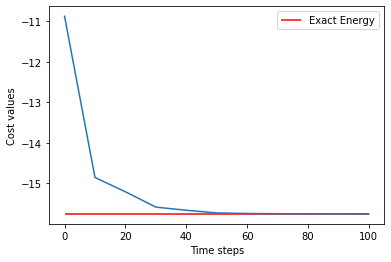

In [35]:
plt.plot(np.linspace(0,100,11),costarr)
plt.hlines(min_eng, 0, 100, color="red", label="Exact Energy")
plt.ylabel("Cost values")
plt.xlabel("Time steps")
plt.legend()
plt.show()

In [36]:
np.array(par_arr[10])

array([ 0.03094014,  0.72032172, -0.14756708,  0.02254578,  0.37050509,
        1.21703208,  1.15565672, -0.13528863, -0.0421788 ,  0.79598792,
        0.31605036,  0.2630098 ,  0.09712496,  0.54661773,  0.01634865,
        0.01738326,  0.58419356,  0.01101273,  0.00451728,  0.06220772,
        0.93271552,  0.12028664, -0.03729248,  0.03533534,  1.48008647,
       -0.00378493,  0.35503081, -0.09487901,  0.42592963, -0.13169798,
       -0.18449121,  0.46098168, -0.11026273,  0.03517478, -0.01458506,
        0.69987743,  0.07453354,  0.06082471, -0.04568978,  1.26603533,
       -0.01324545,  1.17472395, -0.2049671 ,  0.36636411, -0.20834498,
       -0.17318804,  0.40416404, -0.08449382,  0.03482659, -0.02654304,
       -0.24653273,  0.12468359, -0.2317937 ,  0.22036051,  0.15393606,
        0.02742429, -0.23868914, -0.08616072,  0.10596302, -0.05204571,
       -0.02136826,  0.04787545,  0.08352816,  0.03525731, -0.0063706 ,
       -0.38006899, -0.10264929, -0.65473927,  0.66905055,  0.26

In [37]:

final_param=np.array([  0.03094014,  0.72032172, -0.14756708,  0.02254578,  0.37050509,
        1.21703208,  1.15565672, -0.13528863, -0.0421788 ,  0.79598792,
        0.31605036,  0.2630098 ,  0.09712496,  0.54661773,  0.01634865,
        0.01738326,  0.58419356,  0.01101273,  0.00451728,  0.06220772,
        0.93271552,  0.12028664, -0.03729248,  0.03533534,  1.48008647,
       -0.00378493,  0.35503081, -0.09487901,  0.42592963, -0.13169798,
       -0.18449121,  0.46098168, -0.11026273,  0.03517478, -0.01458506,
        0.69987743,  0.07453354,  0.06082471, -0.04568978,  1.26603533,
       -0.01324545,  1.17472395, -0.2049671 ,  0.36636411, -0.20834498,
       -0.17318804,  0.40416404, -0.08449382,  0.03482659, -0.02654304,
       -0.24653273,  0.12468359, -0.2317937 ,  0.22036051,  0.15393606,
        0.02742429, -0.23868914, -0.08616072,  0.10596302, -0.05204571,
       -0.02136826,  0.04787545,  0.08352816,  0.03525731, -0.0063706 ,
       -0.38006899, -0.10264929, -0.65473927,  0.66905055,  0.26200485,
       -0.03025463, -0.16750708,  0.24846927, -0.04097558, -0.1511969])

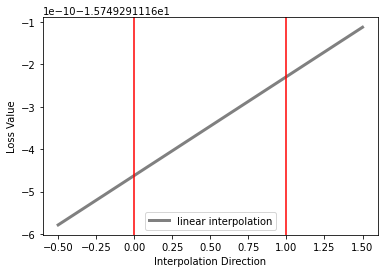

In [38]:
from orqviz.scans import perform_1D_interpolation, plot_1D_interpolation_result
end_points = (-0.5, 1.5)

interpolation_result = perform_1D_interpolation(params, final_param, 
                                                cost_fn, end_points=end_points)

plot_1D_interpolation_result(interpolation_result, label="linear interpolation", color="gray")

plt.legend()
plt.show()

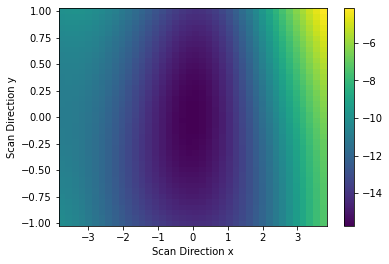

In [39]:
from orqviz.scans import perform_2D_scan, plot_2D_scan_result

dir1 = params
dir2 = orqviz.geometric.get_random_orthonormal_vector(dir1)

scan2D_result = orqviz.scans.perform_2D_scan(final_param, cost_fn,
                                direction_x=dir1, direction_y=dir2,
                                n_steps_x=40)
orqviz.scans.plot_2D_scan_result(scan2D_result)

In [40]:
from orqviz.pca import (get_pca, perform_2D_pca_scan, plot_pca_landscape, 
                        plot_optimization_trajectory_on_pca)

In [41]:
pca = get_pca(par_arr)
scan_pca_result = perform_2D_pca_scan(pca, cost_fn, n_steps_x=40)

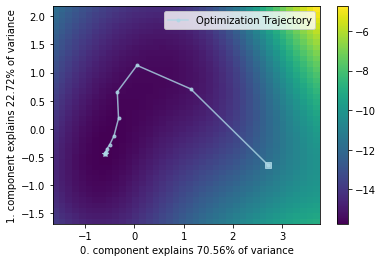

In [42]:
fig, ax = plt.subplots()
plot_pca_landscape(scan_pca_result, pca, fig=fig, ax=ax)
plot_optimization_trajectory_on_pca(par_arr, pca, ax=ax, 
                                    label="Optimization Trajectory", color="lightblue")
plt.legend()
plt.show()

In [43]:
scan_pca_result2 = perform_2D_pca_scan(pca, cost_fn, n_steps_x=40, offset=8)

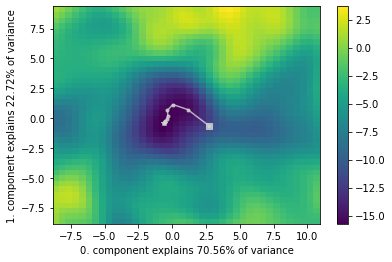

In [44]:
fig, ax = plt.subplots()
plot_pca_landscape(scan_pca_result2, pca, fig=fig, ax=ax)
plot_optimization_trajectory_on_pca(par_arr, pca, ax=ax)